In [1]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import string,os
from  string  import  punctuation     
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.cluster import KMeans

In [2]:
# Read data
df = pd.read_csv('../data/clean_data/clean_data_annotated.csv')

In [3]:
## prerequisite
#python -m spacy download en_core_web_sm

# Data Preprocessing & Text Wrangling 

In [4]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [5]:
nlp = spacy.load('en_core_web_sm', vectors='en_google')
WNlemma = nltk.WordNetLemmatizer()
STOP_WORDS=stopwords.words("English")
custom_stopwords = [word for word in  open(os.path.join('util','custom_stopwords.txt'), "r").read().split() if word not in STOP_WORDS]
mystopwords = STOP_WORDS + custom_stopwords
def transform(text):
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r'''(?i)\b((?:http?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"dead", " death ", text)    
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub("[^a-zA-Z,]"," ",str(text))
    text = text.split(',')[0].lower()
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    return text
def preprocess_nltk(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub("[^a-zA-Z]"," ", str(text))
    tokens = nltk.word_tokenize(text)
    tokens=[ WNlemma.lemmatize(t.lower()) for t in tokens]
    tokens_nop = [ t for t in tokens if t not in string.punctuation]
    tokens_lower=[t.lower() for t in tokens_nop]
    tokens_nostop=[ t for t in tokens_lower if t not in mystopwords]
    tokens_clean = [t for t in tokens_nostop if len(t) >=3]
    return(tokens_clean)
def preprocess_spacy(text, remove_stopwords=True, stem_words=False, punctuations=punctuation):
    # use spacy to do nlp process without parser and NER
    #doc = nlp(text, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-'] # reduce inflectional forms
    tokens = [tok for tok in tokens if tok not in mystopwords and tok not in punctuations]
    text = ' '.join(tokens)
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    text=" ".join(text.split())
    return(tokens)
# generate wordcloud
def gen_wc(text,process_flag,title_txt):
    if process_flag:tokens_clean = preprocess_nltk(text)
    #if process_flag:tokens_clean = preprocess_spacy(text)
    else : tokens_clean = text
    fd_clean = nltk.FreqDist(tokens_clean)
    wc2 = WordCloud(background_color="white")
    wc2.generate_from_frequencies(fd_clean)
    plt.imshow(wc2, interpolation="bilinear")
    plt.title(title_txt)
    plt.axis("off")
    plt.show()
def gene_wc(text,process_flag,title_txt):
    if process_flag:tokens_clean = preprocess_nltk(text)
    #if process_flag:tokens_clean = preprocess_spacy(text)
    else : tokens_clean = text
    fd_clean = nltk.FreqDist(tokens_clean)
    wc2 = WordCloud(background_color="white")
    wc2.generate(text)
    plt.imshow(wc2, interpolation="bilinear")
    plt.title(title_txt)
    plt.axis("off")
    plt.show()
def print_terms(cm, num):
    original_space_centroids = svd.inverse_transform(cm.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(num):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
dict = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5',
        6: '6'}
cluster_labels = [ dict[c] for c in range(6)]


## Subsample into 3 groups
    1) WPSG 
         3 clusters
    2) PAPSG 
         3 clusters
    3) Overall_SingaporeGeneralElection 
        5 clusters

In [6]:
cluster_grp1 ,cluster_grp2 ,cluster_grp3 = 2,2,3
df['Tag'] = df['Tag'].apply(transform) 
keys = df.Tag.value_counts().keys()
mystopwords = mystopwords + keys.tolist()
print('Stopwords count - default : {}, custom : {}, total :{}'.format(len(STOP_WORDS),len(custom_stopwords),len(mystopwords)))
df['Content'] = df['Content'].apply(transform)
df.Tag.value_counts()

Stopwords count - default : 179, custom : 361, total :554


singaporevotes                     2270
general election sg                2250
ge                                  963
general election sg                 956
sgelections                         762
sgelection                          569
ge    sg                            211
singapore general election          179
wpsg                                129
gesg                                117
singapore general election          101
singapore ge                         93
sgge                                 89
papsingapore                         81
Name: Tag, dtype: int64

Dataset (129, 15)


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['general_election_sg', 'general_election_sg2020', 'gesg', 'japan', 'singapore_general_election_2020'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


 Topic Modelling using SVD & K-Mean
Explained variance of the SVD step: 65%
Wall time: 2 ms
Silhouette Coefficient for clusters: 0.277
Cluster 0: aljunied hougang istandwithraeesah jamuslim resident makeyourvotecount jamus thia khiang raeesah
Cluster 1: opposition pritam singh parliament leader covid fight manifesto heng dpm

 Topic Modelling using LDA

Topic #0:
aljunied hougang istandwithraeesah jamuslim makeyourvotecount resident thia khiang sound battle fight dennis sengkanggrc covid politics dpm jamus parliament opposition edinburgh

Topic #1:
opposition jamus pritam hougang singh manifesto parliament raeesah khan stand edinburgh leader heng politics gutter dpm fight covid battle sengkanggrc


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


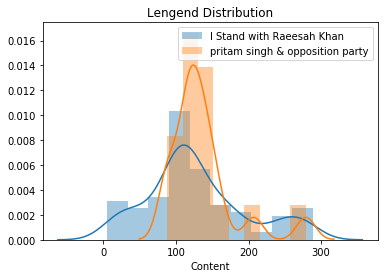

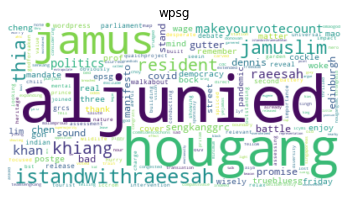

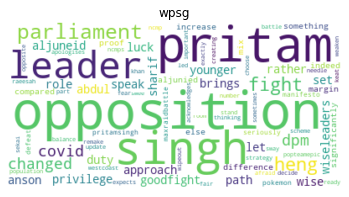

In [7]:
sel_df = df[(df['Tag']=='wpsg')]
print("Dataset {}".format(sel_df.shape))
num_cluster = cluster_grp1
text=sel_df['Content']
toks = text.apply(preprocess_nltk)
vectorizer = TfidfVectorizer(max_df=0.4, max_features=1500,
                             min_df=3, stop_words=mystopwords,use_idf=True)        
X_=[" ".join(token) for token in toks]
X=vectorizer.fit_transform(X_)  
svd = TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
        random_state=42, tol=0.0)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print(" Topic Modelling using SVD & K-Mean")
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
km = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=1000, n_init=1,random_state=4321)
%time km.fit(X_lsa)
labels = df['Tag']
print("Silhouette Coefficient for clusters: %0.3f"% metrics.silhouette_score(X_lsa, km.labels_))
print_terms(km, num_cluster)
print('')
print(" Topic Modelling using LDA")
lda = LDA(n_components=num_cluster, n_jobs=-1)
lda.fit(X)
print_topics(lda, vectorizer, 20)

cluster_labels = [ dict[c] for c in km.labels_]
sel_df['class']= cluster_labels

s1 = sel_df[sel_df['class'] == '0']['Content']
sns.distplot(s1.str.len(), label='I Stand with Raeesah Khan ')
s2 = sel_df[sel_df['class'] == '1']['Content']
sns.distplot(s2.str.len(), label='pritam singh & opposition party')

plt.title('Lengend Distribution')
plt.legend()
for i in range(1,num_cluster+1):
    plt.figure()
    gen_wc(' '.join(eval('s%d'%(i))),True,'wpsg')

Dataset (81, 15)
 Topic Modelling using SVD & K-Mean
Explained variance of the SVD step: 42%
Wall time: 997 µs
Silhouette Coefficient for clusters: 0.709
Cluster 0: opposition chu popularity voice covid slate fight hand manifesto
Cluster 1: covid hand manifesto fight slate chu voice popularity opposition

 Topic Modelling using LDA

Topic #0:
opposition popularity voice slate fight covid chu manifesto hand

Topic #1:
covid chu manifesto hand fight slate opposition voice popularity


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['general_election_sg', 'general_election_sg2020', 'gesg', 'japan', 'singapore_general_election_2020'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


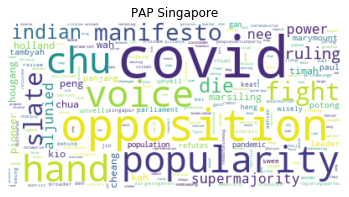

In [8]:
sel_df = df[(df['Tag']=='papsingapore')]
print("Dataset {}".format(sel_df.shape))
num_cluster = cluster_grp2
text=sel_df['Content']
toks = text.apply(preprocess_nltk)
vectorizer = TfidfVectorizer(max_df=0.4, max_features=1500,
                             min_df=3, stop_words=mystopwords,use_idf=True)        
X_=[" ".join(token) for token in toks]
X=vectorizer.fit_transform(X_)  
svd = TruncatedSVD(algorithm='randomized', n_components=3, n_iter=100,
        random_state=42, tol=0.0)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print(" Topic Modelling using SVD & K-Mean")
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
km = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=1000, n_init=1,random_state=4321)
%time km.fit(X_lsa)
labels = df['Tag']
print("Silhouette Coefficient for clusters: %0.3f"% metrics.silhouette_score(X_lsa, km.labels_))
print_terms(km, num_cluster)
print('')
print(" Topic Modelling using LDA")
lda = LDA(n_components=num_cluster, n_jobs=-1)
lda.fit(X)
print_topics(lda, vectorizer, 20)
gen_wc(' '.join(X_),True,'PAP Singapore')

Dataset (8560, 15)


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['general_election_sg', 'general_election_sg2020', 'gesg', 'japan', 'singapore_general_election_2020'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


 Topic Modelling using SVD & K-Mean
Explained variance of the SVD step: 10%
Wall time: 8.98 ms
Silhouette Coefficient for clusters: 0.285
Cluster 0: noblankcheque polling parliament station opposition upcoming real update stcom dissolve
Cluster 1: opposition covid pandemic politics coronavirus parliament amid power leader polling
Cluster 2: ruling majority power opposition covid pandemic coronavirus mandate politics parliament

 Topic Modelling using LDA

Topic #0:
polling covid leehsienloong friday power special strait pandemic aljunied real eye stcom full update analysis unveils watershed challenge amid jones

Topic #1:
parliament opposition polling station contested open hotly hour pritam leader singh voice dissolved million latest yacob counting halimah tomorrow covid

Topic #2:
noblankcheque ruling upcoming politics majority head constituency opposition lim mandate pandemic god coronavirus parliament icymi heng votepapout hougang mao set


C:\Users\tyzn_arthur\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


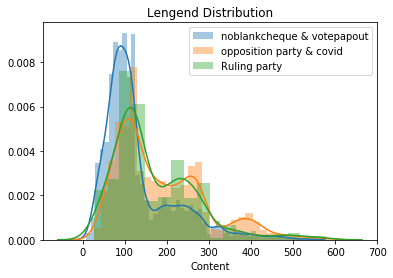

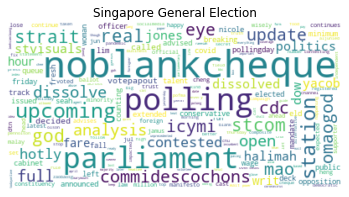

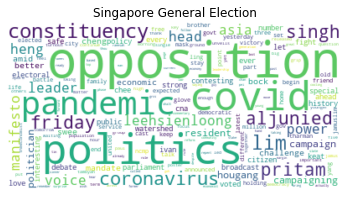

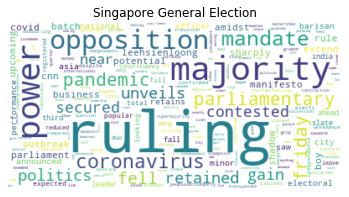

In [9]:
sel_df = df[(df['Tag']!='wpsg') & (df['Tag']!='papsingapore')]
print("Dataset {}".format(sel_df.shape))
num_cluster = cluster_grp3
text=sel_df['Content']
toks = text.apply(preprocess_nltk)
vectorizer = TfidfVectorizer(max_df=0.4, max_features=1500,
                             min_df=3, stop_words=mystopwords,use_idf=True)        
X_=[" ".join(token) for token in toks]
X=vectorizer.fit_transform(X_)  
svd = TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
        random_state=42, tol=0.0)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print(" Topic Modelling using SVD & K-Mean")
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
km = KMeans(n_clusters=num_cluster, init='k-means++', max_iter=1000, n_init=1,random_state=4321)
%time km.fit(X_lsa)
labels = df['Tag']
print("Silhouette Coefficient for clusters: %0.3f"% metrics.silhouette_score(X_lsa, km.labels_))
print_terms(km, num_cluster)
print('')
print(" Topic Modelling using LDA")
lda = LDA(n_components=num_cluster, n_jobs=-1)
lda.fit(X)
print_topics(lda, vectorizer, 20)

cluster_labels = [ dict[c] for c in km.labels_]
sel_df['class']= cluster_labels

s1 = sel_df[sel_df['class'] == '0']['Content']
sns.distplot(s1.str.len(), label='noblankcheque & votepapout')
s2 = sel_df[sel_df['class'] == '1']['Content']
sns.distplot(s2.str.len(), label='opposition party & covid')
s3 = sel_df[sel_df['class'] == '2']['Content']
sns.distplot(s3.str.len(), label='Ruling party ')

plt.title('Lengend Distribution')
plt.legend()
for i in range(1,num_cluster+1):
    plt.figure()
    gen_wc(' '.join(eval('s%d'%(i))),True,'Singapore General Election')